In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
figsize(10, 8)

In [4]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [5]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [40]:
np.pi / ( 4. * np.log(2))

1.1330900354567985

In [57]:
def calculate_sflux(bank='A', session='5', doplot=True, pixbeam=4.):
    rc = 335.7
    dc = 63.4
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units !!
    # units now are Jy * beam area per pixel area
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    signal = gaussian_filter(signal, beam/pixbeam)
    shits = gaussian_filter(hits, beam/pixbeam)
    maskz = shits == 0.
    signal[maskz] = np.nan
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    if doplot:
        figure()
        pc = pcolormesh(rabins, decbins, signal)
        clim(-0.1*units, 0.1*units)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Flux [Jy]')
    
    flux = np.nansum(signal[innerregion] - np.nanmedian(signal[outerregion]))
    return flux

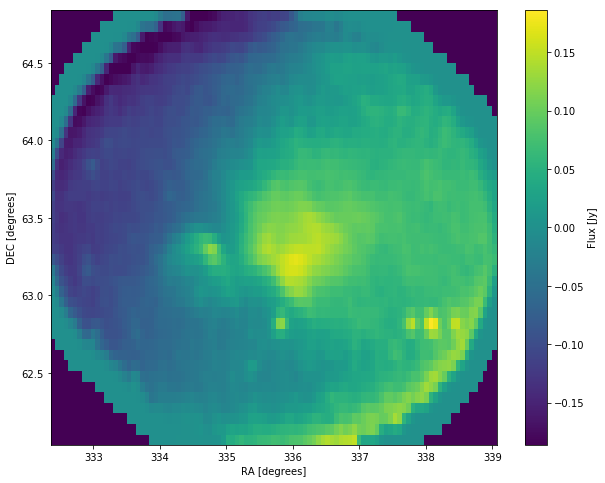

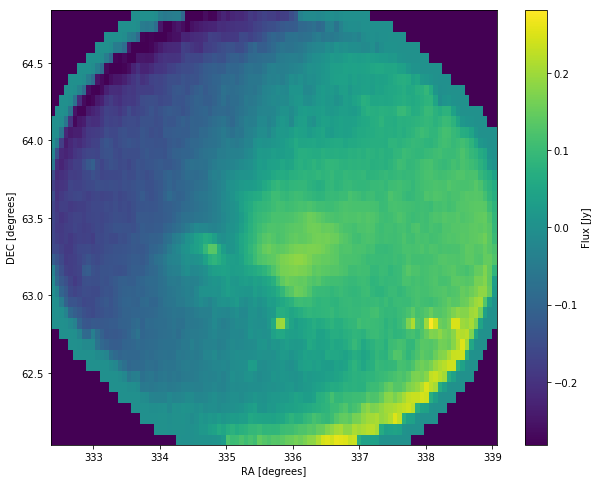

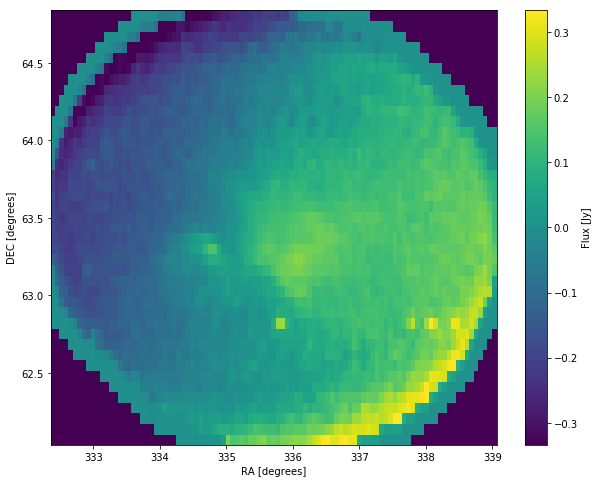

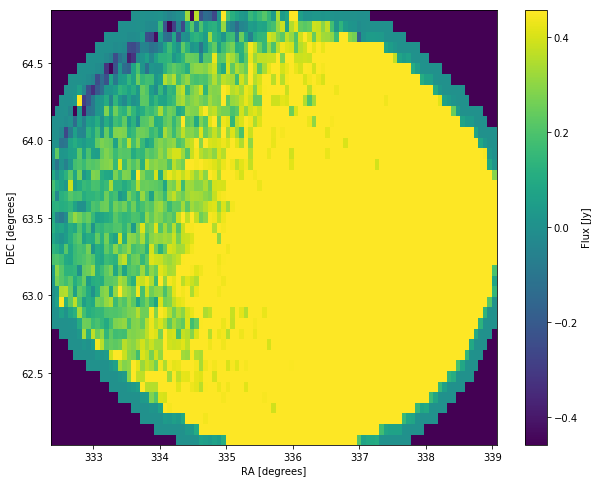

In [58]:
fluxs5 = []
for bank in banks:
    fluxs5.append(calculate_sflux(bank, '5'))

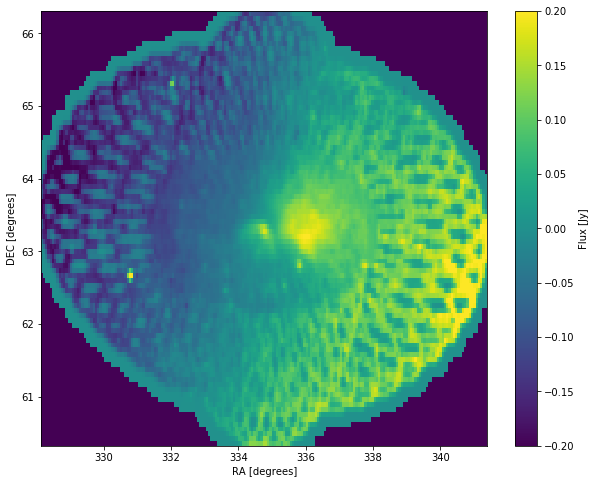

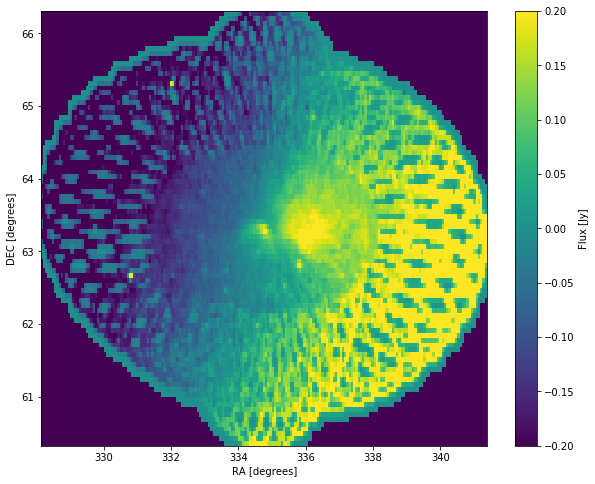

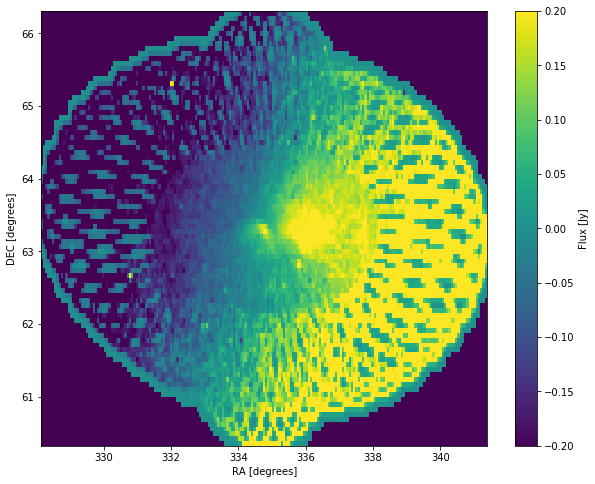

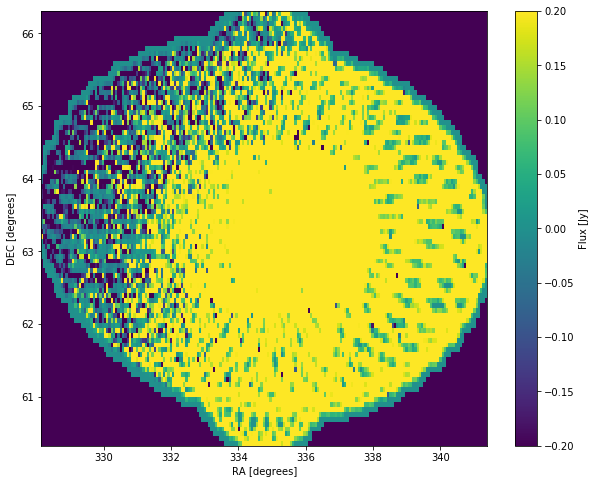

In [54]:
fluxs2 = []
for bank in banks:
    fluxs2.append(calculate_sflux(bank, '2'))

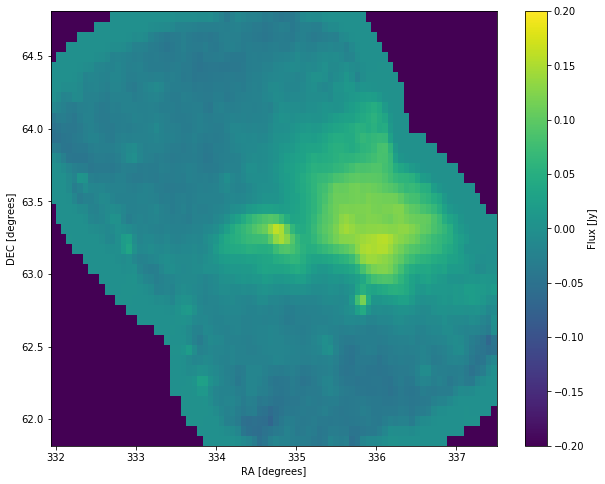

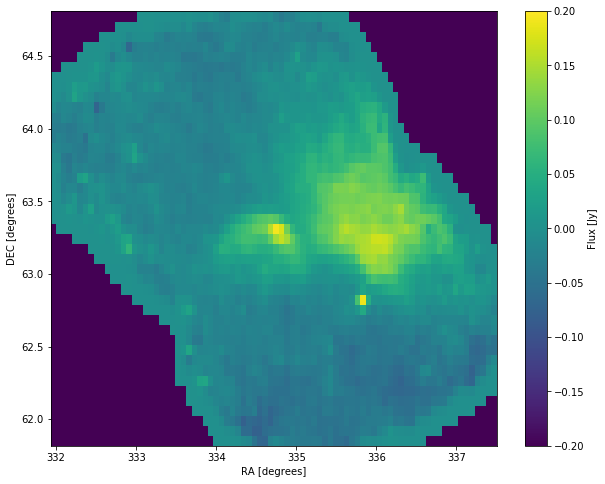

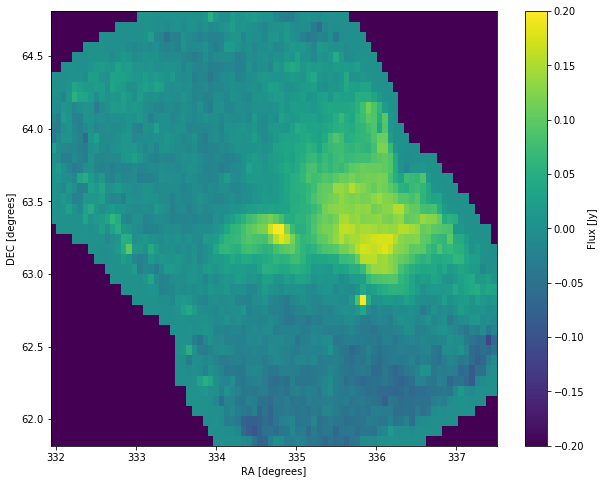

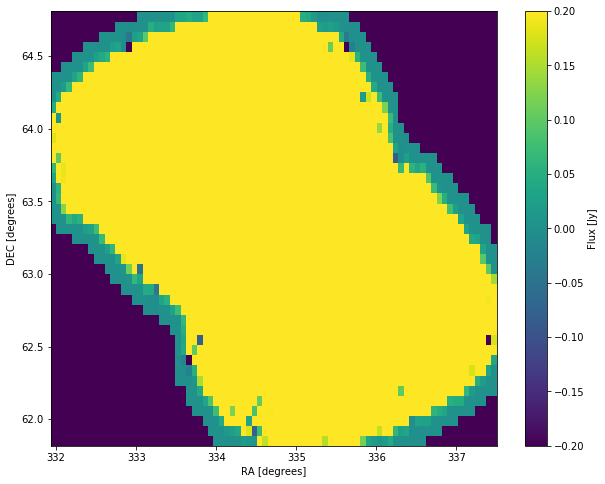

In [55]:
fluxs3 = []
for bank in banks:
    fluxs3.append(calculate_sflux(bank, '3'))

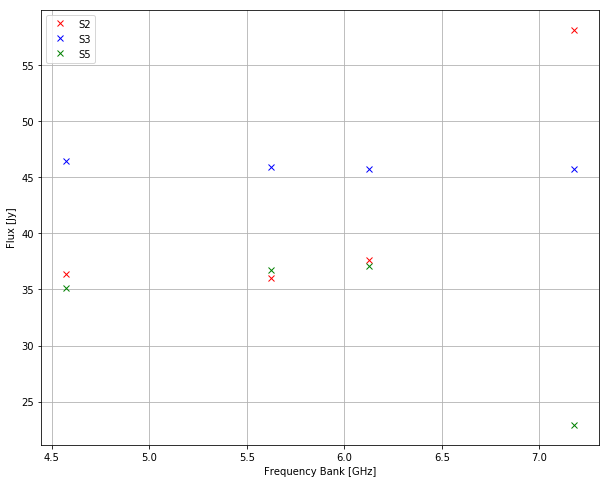

In [56]:
plot(freqs, fluxs2, 'xr', label='S2')
plot(freqs, fluxs3, 'xb', label='S3')
plot(freqs, fluxs5, 'xg', label='S5')
ylabel('Flux [Jy]')
xlabel('Frequency Bank [GHz]')
legend()
grid()

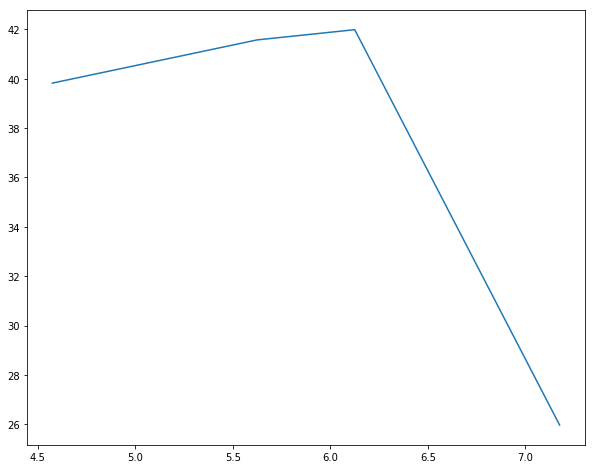

In [27]:
plot(freqs, fluxs)

In [32]:
sbeams = np.linspace(0.5, 6., 30)

In [9]:
sfluxs = []
for sbeam in sbeams:
    sfs = calculate_sflux('A', '5', doplot=False, pixbeam=sbeam)
    sfluxs.append(sfs)
sfluxs = np.array(sfluxs)

In [10]:
sfluxs2 = []
for sbeam in sbeams:
    sfs = calculate_sflux('B', '5', doplot=False, pixbeam=sbeam)
    sfluxs2.append(sfs)
sfluxs2 = np.array(sfluxs2)

In [11]:
sfluxs3 = []
for sbeam in sbeams:
    sfs = calculate_sflux('C', '5', doplot=False, pixbeam=sbeam)
    sfluxs3.append(sfs)
sfluxs3 = np.array(sfluxs3)

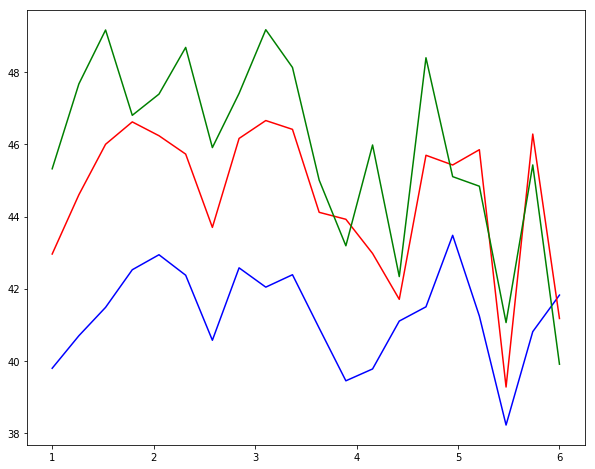

In [20]:
plot(sbeams, sfluxs, 'b')
plot(sbeams, sfluxs2, 'r')
plot(sbeams, sfluxs3, 'g')

In [15]:
np.std(sfluxs) / np.mean(sfluxs)

0.030972148829384264

In [16]:
np.std(sfluxs2) / np.mean(sfluxs2)

0.045353295392679641

In [17]:
np.std(sfluxs3) / np.mean(sfluxs3)

0.055949952278446312

In [35]:
sbeams = np.linspace(0.5, 10., 40)

In [36]:
sfluxs = []
for sbeam in sbeams:
    sfs = calculate_sflux('A', '3', doplot=False, pixbeam=sbeam)
    sfluxs.append(sfs)
sfluxs = np.array(sfluxs)

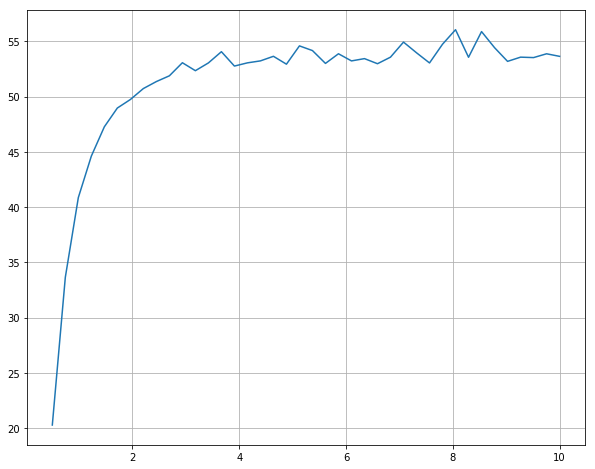

In [37]:
plot(sbeams, sfluxs)
grid()

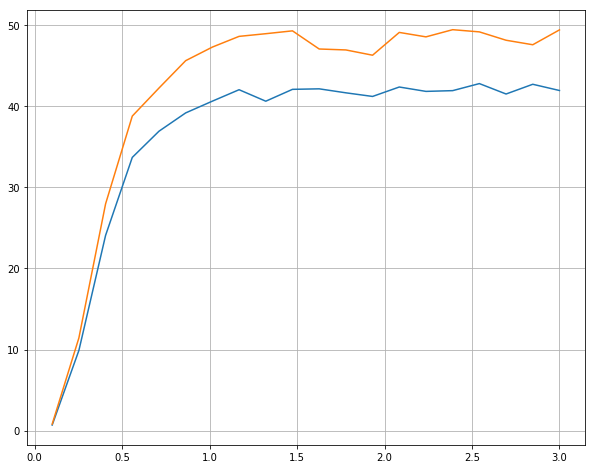

In [22]:
plot(sbeams, sfluxs * corrections)
plot(sbeams, sfluxs3 * corrections3)
grid()